<p align="left">
  <img src="./logo_UTN.svg" />
</p>


# **Teoría de Circuitos II - R4001 - 2023**
## Trabajo Semanal 5
### Autor: Bruno Glecer

# Consigna

Se debe diseñar un filtro pasa-altos, que presente máxima planicidad en la banda de paso (frecuencia de corte = 300 Hz) y un cero de transmisión en 100 Hz. El prototipo pasabajos normalizado presenta la siguiente respuesta:

<div>
    <img src="bode_pasabajos.png" width="500"/>
</div>

1. Determine la expresión de H(s) del filtro pasa-altos normalizado                    
2. Realizar el diagrama de polos y ceros de H(s)                                             
3. Sintetice el circuito del filtro pedido. Se utilizará para la estructura de segundo orden el siguiente circuito:

<div>
    <img src="circuito_propuesto.png" width="500"/>
</div>

4. Compare la estructura sugerida y discuta las similitudes y diferencias con la red propuesta por Schaumann:

<div>
    <img src="circuito_schaumann.png" width="500"/>
</div>


# 1. Transferencia del filtro pasa altos

Comenzamos este ejercicio planteando las caracteristicas que la consigna nos da a conocer del filtro prototipo (pasa bajos) y el objetivo (pasa altos).

### Pasa bajos
Analizando visualmente el diagrama de Bode, podemos deducir:
- **Cero de transmision en $\Omega_n=3$**
- **Asintota de -20db/dec tendiendo a frecuencias altas.**
- **Ganancia tiende a 0dB para frecuencias bajas**

### Pasa altos
- **Cero de transmision en $\omega=2\pi ~ 100\mathrm{Hz}$**
- **Presenta maxima planicidad en la banda de paso con frecuencia de corte $\omega=2\pi ~ 300\mathrm{Hz}$**

### Verificacion de norma de frecuencia

El nucleo de transformacion de frecuencia que define la relacion entre $\omega$ y $\Omega$ es $p = K(s) = \dfrac{1}{s}$. En particular, $|\Omega| = \dfrac{1}{|\omega|}$ para $\sigma = \Sigma = 0$

Como el cero de transmision se encuentra en $\Omega_n = 3$ para el pasa bajos, se encontrará en $\omega_n = \dfrac{1}{3}$ para el pasa altos. Por el enunciado, tambien sabemos que en terminos de la frecuencia desnormalizada, el cero se encuentra en $\omega=2\pi ~ 100\mathrm{Hz}$. Haciendo la division entre estos dos valores podemos encontrar la norma de frecuencia que se utilizó para el diagrama de Bode:

$$\dfrac{\omega_{(cero)}}{\omega_{n(cero)}} = \dfrac{2\pi ~ 100\mathrm{Hz}}{\dfrac{1}{3}} = 2\pi ~ 300\mathrm{Hz}$$

Esta es la misma frecuencia que la del corte del filtro pasa altos, lo cual es de esperar, ya que $\omega_s = 1$ es una condicion necesaria para que el nucleo de transformación elegido sea valido.

### Polos y ceros pasa bajos

Hasta ahora sabemos que el filtro pasa bajos, tiene:

- Un par de ceros conjugados ubicados en $p = \pm 3j$
- $n$ polos ubicados alrededor de la semi-circunferencia con radio $\Omega_s = 1$

Para deducir el orden del filtro ($n$), podemos hacer uso de la pendiente de la asintota tendiendo a frecuencias altas. Usando los metodos de analisis graficos de diagramas de Bode asintoticos, podemos ver como se relaciona con los ceros de transmision y los polos del filtro:

<div>
    <img src="bode_lp_asym.png" width="400"/>
</div>

Como en el diagrama de Bode de la cosigna la asintota es de -20dB/dec, podemos concluir que el filtro tiene que ser de orden $n=3$ (tres polos).

La consigna no proporciona informacion sobre la atenuacion en la frecuencia de corte, asi que asumimos que la contribucion del filtrado es el estandard de -3dB. En terminos de los parametros de la transferencia de maxima planicidad, corresponde a $\varepsilon = 1$

#### Ceros

Los unicos ceros es el par de ceros conjugados en $p = \pm 3j$. Entonces el numerador tiene la siguiente forma:

$N_{LP}(p) = (p + 3j)(p - 3j) = p^2 + 9$

#### Polos

Los unicos polos corresponden al filtrado de maxima planicidad. Para obtener los polos podemos utilizar el metodo geometrico en base a los angulos:

- **Polo singular**: $\omega_0 = 1$

- **Polos conjugados**: $\omega_0 = 1 ~~~ Q=\dfrac{1}{2 cos(\dfrac{\pi}{3})} = 1$

$D_{LP}(p) = (p + 1)(p^2 + p + 1) = p^3 + 2 p^2 + 2p + 1$

#### Ganancia

Combinando los polos y ceros para formar la transferencia se obtiene:

$H_{LP}(p) = K \dfrac{N_{LP}(p)}{D_{LP}(p)} = K \dfrac{p^2 + 9}{p^3 + 2 p^2 + 2p + 1}$

Pero aun hay que encontrar $K$ para que se cumpla la condicion de ganancia de $0dB$ en las frecuencias bajas.
La fraccion tiende a $9$ cuando $p \to 0$, para lograr que tienda a $1$ (0dB), tenemos que elegir $K=\dfrac{1}{9}$


#### Transferencia

$H_{LP}(p) = \dfrac{1}{9} \dfrac{p^2 + 9}{p^3 + 2 p^2 + 2p + 1}$


### Transformacion en frecuencia

Utilizando el nucleo de transformacion, podemos transformar la transferencia al filtro objetivo pasa altos y asi obtener la funcion de transferencia final.

$H(s) = \dfrac{s^3 + \dfrac{1}{9}s}{s^3 + 2 s^2 + 2s + 1}$

# 2. Graficos y verificacion

Utilizando python podemos realizar el analisis de la funcion de transferencia para verificar que cumpla con los requisitos iniciales.

(2, <Axes: xlabel='$\\sigma$', ylabel='j$\\omega$'>)

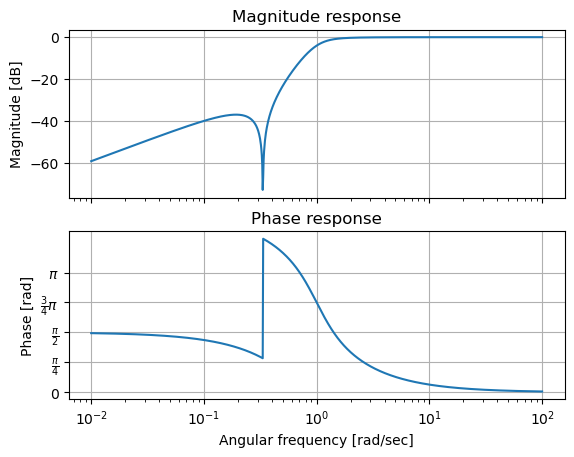

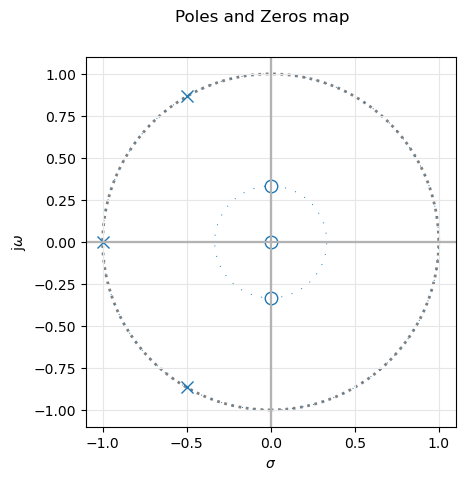

In [1]:
from scipy import signal
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq,tfcascade,pretty_print_lti, bodePlot, pzmap

h = signal.TransferFunction([1, 0, 1/9, 0], [1, 2, 2, 1])

bodePlot(h)
pzmap(h)

Mirando el grafico de la respuesta de modulo, se puede ver claramente la asintota de 20dB/dec, hasta llegar al cero de transmision en $\omega = \dfrac{1}{3}$ $( f=100\mathrm{Hz})$. Despues aumenta su pendiente a aproximadamente 60dB/dec, hasta $\omega = 1$ $(f=300\mathrm{Hz})$ donde llega a su maximo de 0dB.

El grafico de polos y ceros muestra lo que esperamos, los polos del filtrado de maxima planicidad en la circunferencia $\omega_0 = 1$, los ceros conjugados en $\omega = \dfrac{1}{3}$ y un cero en el origen producto de que se trata de un filtro pasa altos.

# 3. Implementacion con la estructura propuesta

## Separacion de la transferencia en bilineal y biquad

La funcion de transferencia que se desea implementar es: $H(s) = \dfrac{s^3 + \dfrac{1}{9}s}{s^3 + 2 s^2 + 2s + 1}$

Separando en polos y ceros, simples y conjugados: $H(s) = \dfrac{s \left(s^2 + \dfrac{1}{9}\right)}{\left(s + 1\right) \left( s^2 + s + 1 \right)}$

Y separando en un termino bilineal y otro bicuadratico: $H(s) = \dfrac{s}{s + 1} \dfrac{s^2 + \dfrac{1}{9}}{s^2 + s + 1}$

## Implementacion de la etapa bicuadratica

Para poder utilizar la etapa de segundo orden propuesta, debemos encontrar como será su funcion de transferencia parametrizada con los valores de los componentes. Para simplificar el analisis, usaremos Python junto con la libreria SymPy para encontrar la transferencia.

Primero empezamos nombrando todas las tensiones y corrientes del circuito

<div>
    <img src="analisis_circuito.png" width="700"/>
</div>

Ahora utilizamos el siguiente script para encontrar la transferencia

In [2]:
from sympy import solve, symbols, Eq


#Variables conocidas
G1, G2, G, C, s = symbols("G1 G2 G C s")

#Variables desconocidas
H, Vi, Vo, V1, V2, Ii, I1, I2, I3, I4, I5, I6, I7 = symbols("H Vi Vo V1 V2 Ii I1 I2 I3 I4 I5 I6 I7")
unknowns = [H, Vi, Vo, V1, V2, Ii, I1, I2, I3, I4, I5, I6, I7]

equations = []

#Ecuaciones de nodos
equations.append(Eq(Ii + I7, I1))
equations.append(Eq(I1, I2 + I3))
equations.append(Eq(I3, I4 + I5))
equations.append(Eq(I5, I6 + I7))


#Ecuaciones de componentes
equations.append(Eq((Vi - V1)*s*C, I1))
equations.append(Eq(V1*G1, I2))
equations.append(Eq((V1 - V2)*G2, I3))
equations.append(Eq((V2 - V1)*G, I5))
equations.append(Eq((V1 - Vo)*G, I5))
equations.append(Eq((Vo - V1)*s*C, I7))
equations.append(Eq((V1 - Vi)*G, I7))


#Relacion de H con tensiones
equations.append(Eq(H, Vo/Vi))

#Resolver
sol_H = solve(equations, unknowns, dict=True)[0][H]

sol_H

(C**2*s**2 - G*G1 + G*G2)/(C**2*s**2 + C*G1*s + G*G2)

Reordenando los terminos para mayor claridad:

$T(s) = \dfrac{s^2 + \dfrac{G}{C^2}(G_2 - G_1)}{s^2 + \dfrac{G_1}{C}s + \dfrac{G G_2}{C^2}}$



Para implementar la transferencia $H_2(s) = \dfrac{s^2 + \dfrac{1}{9}}{s^2 + s + 1}$ usando la estructura propuesta, debemos elegir los valores tal que:

- $\dfrac{G}{C^2}(G_2 - G_1) = \dfrac{1}{9}$

- $\dfrac{G_1}{C} = 1$

- $\dfrac{G G_2}{C^2} = 1$

Este sistema de ecuaciones no esta restringido, tiene un grado de libertad de más. Para restringirlo a una sola solución hay que elegir un valor de algun componente y fijarlo. Para esto tomamos $C=1$

Esto resulta en los siguientes valores:

- $C = 1$

- $R = \dfrac{9}{8}$

- $R_1 = 1$

- $R_2 = \dfrac{8}{9}$

## Implementacion de la etapa bilineal

La funcion de transferencia de la etapa de primer orden es simplemente: $\dfrac{s}{s + 1}$

Para esto podemos usar un filtro pasa altos RC con $\omega_0 = 1$

<div>
    <img src="etapa_bilineal.png" width="500"/>
</div>

## Implementacion final

Aprovechamos la salida de baja impedancia del opamp de la etapa biquad para no tener que usar un seguidor de tension entre las etapas. Entonces, colocamos primero la etapa biquad seguido de la bilineal. Resultando en el circuito deseado

<div>
    <img src="circuito_final.png" width="800"/>
</div>


# 4. Comparación con estructura biquad general propuesta por Schaumann

<div>
    <img src="circuito_schaumann.png" width="500"/>
</div>


La red que se muestra arriba se puede ver a simple vista que es una version mas completa a la propuesta en el ejercicio. Las dos diferencias mayores son: Primero,  la red RC pasa altos compuesta por C y R1 que se encuentra en la estructura propuesta, fue generalizada a una red RC que puede implementar cualqier bilineal (excepto por transferencias con ceros positivos) dependiendo de los parametros $a$ y $b$. La segunda diferencia es que la resistencia R5 fue desdoblada hacia masa, ajustable por el parametro $c$.

La transferencia normalizada completa esta dada por la siguiente expresion:

$T(s) = \dfrac{s^2(2a - c) + \dfrac{2b-c}{Q}s + c}{s^2 + \dfrac{1}{Q}s + 1}$

A simple vista se ve como este tiene un termino lineal en el numerador, permitiendo la implementacion de filtros elimina banda que no sean notch o incluso un pasa banda. Tambien se puede anular el termino cuadratico permitiendo la implementacion de pasa bajos.

El filtro propuesto en el enunciado se puede implementar utilizando los siguientes parametros de diseño:

- $a = \dfrac{5}{9}$

- $b = \dfrac{1}{18}$

- $c = \dfrac{1}{9}$

Y eligiendo los valores de componentes tal que:

- $\omega_0 = \dfrac{1}{RC}$

# 5. Simulaciones

Para verificar la correcta realizacion de los filtros utilizamos LTSpice para la simulacion de las dos implementaciones de los filtros.
A continuacion se muestra el esquematico de la simulacion

<div>
    <img src="sim.png" width="1000"/>
</div>

Vo1 corresponde a la señal de salida de la estructura implementada usando la primer estructura.

Vo2 corresponde a la señal de salida de la estructura propuesta por Schaumann.

A continuacion se muestran los resultados de la simulacion

<div>
    <img src="sim_res.png" width="600"/>
</div>

Como es de esperar ambas respuestas son identicas y se superponen. Tambien corresponden correctamente con el comportamiento especificado en la consigna.

# Conclusiones

La consigna de esta tarea es fundamentalmente distintas a las anteriores, ya que en las otras, siempre se planteó una plantilla para basar el diseño del filtro. En este caso, el objetivo fue dado en la forma de diagramas de Bode del cual hay que extraer sus caracteristicas para lograr llegar a una combinacion de transferencias bilineales y bicuadraticas. Los metodos vistos en las ultimas clases sirvieron para dar el paso de diseñar partiendo de plantillas bien definidas usando un metodo algoritimico a diseñar utilizando metodos menos sistematicos partiendo de una multitud de caractersitcas diferentes, como ser ceros de transmision, pendientes de roll-off y ganancias en ciertos puntos.

